In [115]:
import pandas as pd
import numpy as np
import pydicom
import os
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from multiprocessing import Pool, cpu_count
from matplotlib import patches, patheffects
import math
from pathlib import Path

from fastai.dataset import *
from fastai.conv_learner import *
from fastai.imports import *
from fastai.structured import *

import pdb

import pickle
from sklearn.model_selection import train_test_split

from IPython.display import FileLink
% load_ext autoreload
% autoreload 2
% matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [116]:
ddir = "/home/edwin/Datasets/competitions/rsna-pneumonia-detection-challenge"
rsna_path = Path(ddir)

detailed_class_info_csv = pd.read_csv(rsna_path/'stage_1_detailed_class_info.csv')
stage_1_sample_submission_csv = pd.read_csv(rsna_path/'stage_1_sample_submission.csv')
stage_1_train_labels_csv = pd.read_csv(rsna_path/'stage_1_train_labels.csv')

In [3]:
BBOX_CSV_CORNERS = '../tmp/df_sample_bbox_corners.csv'

In [6]:
! ls {rsna_path}

GCP%20Credits%20Request%20Link%20-%20RSNA.txt  stage_1_train_labels.csv.zip
models					       test
sample					       test2
stage_1_detailed_class_info.csv		       test2_png
stage_1_detailed_class_info.csv.zip	       test_png
stage_1_sample_submission.csv		       tmp
stage_1_test_images.zip			       train
stage_1_train_images.zip		       train_png
stage_1_train_labels.csv


In [6]:
f_model=resnet34
sz=224
bs=64

tfms = tfms_from_model(f_model, sz, crop_type=CropType.NO, tfm_y=TfmType.COORD)

In [10]:
md_bbox = ImageClassifierData.from_csv(rsna_path, 'train', BBOX_CSV_CORNERS, tfms=tfms, bs=64, suffix='.dcm', 
                                       continuous=True)

In [15]:
df_bbox = pd.read_csv(BBOX_CSV_CORNERS)

In [17]:
stage_1_train_labels_csv[:5]

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1


In [73]:
len(stage_1_train_labels_csv)

28989

In [74]:
len(detailed_class_info_csv)

28989

In [346]:
merged_csv = pd.merge(stage_1_train_labels_csv, detailed_class_info_csv, on='patientId').drop_duplicates()

In [347]:
len(merged_csv)

28989

In [339]:
len(merged_csv.patientId.unique())

25684

In [160]:
len(merged_csv)

35875

In [21]:
rsna_merged_labels = '../tmp/rsna_merged_labels.csv'

In [355]:
merged_csv.to_csv(rsna_merged_labels, index=False)

In [22]:
merged_csv = pd.read_csv(rsna_merged_labels)

In [356]:
merged_csv = pd.read_csv(rsna_merged_labels); merged_csv[:10]

,patientId,x,y,width,height,Target,class,codes,bbox_corners
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,1,0 0 0 0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,1,0 0 0 0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,1,0 0 0 0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0,Normal,2,0 0 0 0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1,Lung Opacity,0,264.0 152.0 477.0 531.0
5,00436515-870c-4b36-a041-de91049b9ab4,562.0,152.0,256.0,453.0,1,Lung Opacity,0,562.0 152.0 818.0 605.0
6,00569f44-917d-4c86-a842-81832af98c30,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,1,0 0 0 0
7,006cec2e-6ce2-4549-bffa-eadfcd1e9970,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,1,0 0 0 0
8,00704310-78a8-4b38-8475-49f4573b2dbb,323.0,577.0,160.0,104.0,1,Lung Opacity,0,323.0 577.0 483.0 681.0
9,00704310-78a8-4b38-8475-49f4573b2dbb,695.0,575.0,162.0,137.0,1,Lung Opacity,0,695.0 575.0 857.0 712.0


In [158]:
len(detailed_class_info_csv)

28989

In [351]:
def bbox_corners(row):
    x = row['x']
    y = row['y']
    width = row['width']
    height = row['height'] 
    if math.isnan(x):
        return "0 0 0 0"
    
    x2 = x + width
    y2 = y + height
    return f"{x} {y} {x2} {y2}"

In [352]:
merged_csv['codes'] = merged_csv['class'].astype('category').cat.codes

In [353]:
merged_csv[:10]

,patientId,x,y,width,height,Target,class,codes
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,1
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,1
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,1
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0,Normal,2
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1,Lung Opacity,0
5,00436515-870c-4b36-a041-de91049b9ab4,562.0,152.0,256.0,453.0,1,Lung Opacity,0
6,00569f44-917d-4c86-a842-81832af98c30,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,1
7,006cec2e-6ce2-4549-bffa-eadfcd1e9970,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,1
8,00704310-78a8-4b38-8475-49f4573b2dbb,323.0,577.0,160.0,104.0,1,Lung Opacity,0
9,00704310-78a8-4b38-8475-49f4573b2dbb,695.0,575.0,162.0,137.0,1,Lung Opacity,0


In [354]:
merged_csv['bbox_corners'] = merged_csv.apply(bbox_corners, axis=1)

In [97]:
row = merged_csv.iloc[0]; row

patientId    0004cfab-14fd-4e49-80ba-63a80b6bddd6
x                                             NaN
y                                             NaN
width                                         NaN
height                                        NaN
Target                                          0
class                No Lung Opacity / Not Normal
Name: 0, dtype: object

In [102]:
merged_csv[:10]

,patientId,x,y,width,height,Target,class,bbox_corners
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,0 0 0 0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,0 0 0 0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,0 0 0 0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0,Normal,0 0 0 0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1,Lung Opacity,264.0 152.0 477.0 531.0
5,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1,Lung Opacity,264.0 152.0 477.0 531.0
6,00436515-870c-4b36-a041-de91049b9ab4,562.0,152.0,256.0,453.0,1,Lung Opacity,562.0 152.0 818.0 605.0
7,00436515-870c-4b36-a041-de91049b9ab4,562.0,152.0,256.0,453.0,1,Lung Opacity,562.0 152.0 818.0 605.0
8,00569f44-917d-4c86-a842-81832af98c30,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,0 0 0 0
9,006cec2e-6ce2-4549-bffa-eadfcd1e9970,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,0 0 0 0


In [357]:
sample_csv = merged_csv.sample(n=1000)

In [358]:
sample_csv[['patientId','codes']].to_csv('../tmp/sample_with_class.csv', index=False)

In [359]:
sample_csv[['patientId','bbox_corners']].to_csv('../tmp/sample_with_bbox_corners.csv', index=False)

In [360]:
SAMPLE_LABELS_CSV = pd.read_csv('../tmp/sample_with_class.csv')

In [3]:
SAMPLE_LABELS_CSV_FN = '../tmp/sample_with_class.csv'

In [362]:
SAMPLE_LABELS_BBOX = pd.read_csv('../tmp/sample_with_bbox_corners.csv')

In [4]:
SAMPLE_LABELS_BBOX_FN = '../tmp/sample_with_bbox_corners.csv'

In [117]:
md = ImageClassifierData.from_csv(rsna_path, 'train', SAMPLE_LABELS_CSV_FN, bs=64, 
                                  tfms=tfms_from_model(f_model, sz), suffix='.dcm')
md2 = ImageClassifierData.from_csv(rsna_path, 'train', SAMPLE_LABELS_BBOX_FN, bs=64, 
                                   tfms=tfms, suffix='.dcm', continuous=True)

In [118]:
class ConcatLblDataset(Dataset):
    def __init__(self, ds, y2): 
        self.ds,self.y2 = ds,y2
        self.sz = ds.sz
    def __len__(self): return len(self.ds)
    
    def __getitem__(self, i):
        x,y = self.ds[i]
        return (x, (y,self.y2[i]))

In [124]:
len(tfms)

2

In [121]:
trn_ds_2 = ConcatLblDataset(md2.trn_ds, md.trn_y)
val_ds_2 = ConcatLblDataset(md2.val_ds, md.val_y)

In [122]:
md2.trn_dl.dataset = trn_ds_2
md2.val_dl.dataset = val_ds_2

In [126]:
learn.set_data(md2)

In [127]:
learn.lr_find()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss                            
    0      64.000853  9358.290381



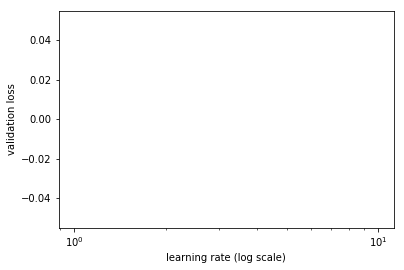

In [128]:
learn.sched.plot()

In [52]:
x, y = next(iter(md2.trn_dl))

In [23]:
merged_csv[:10]

,patientId,x,y,width,height,Target,class,codes,bbox_corners
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,1,0 0 0 0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,1,0 0 0 0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,1,0 0 0 0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0,Normal,2,0 0 0 0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1,Lung Opacity,0,264.0 152.0 477.0 531.0
5,00436515-870c-4b36-a041-de91049b9ab4,562.0,152.0,256.0,453.0,1,Lung Opacity,0,562.0 152.0 818.0 605.0
6,00569f44-917d-4c86-a842-81832af98c30,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,1,0 0 0 0
7,006cec2e-6ce2-4549-bffa-eadfcd1e9970,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,1,0 0 0 0
8,00704310-78a8-4b38-8475-49f4573b2dbb,323.0,577.0,160.0,104.0,1,Lung Opacity,0,323.0 577.0 483.0 681.0
9,00704310-78a8-4b38-8475-49f4573b2dbb,695.0,575.0,162.0,137.0,1,Lung Opacity,0,695.0 575.0 857.0 712.0


In [26]:
merged_csv['class'].unique()

array(['No Lung Opacity / Not Normal', 'Normal', 'Lung Opacity'], dtype=object)

In [53]:
head_reg4 = nn.Sequential(
    Flatten(),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(25088,256),
    nn.ReLU(),
    nn.BatchNorm1d(256),
    nn.Dropout(0.5),
    nn.Linear(256,4+3),
)
models = ConvnetBuilder(f_model, 0, 0, 0, custom_head=head_reg4)

learn = ConvLearner(md2, models)
learn.opt_fn = optim.Adam

In [54]:
def detn_loss(input, target):
    bb_t,c_t = target
    bb_i,c_i = input[:, :4], input[:, 4:]
    bb_i = F.sigmoid(bb_i)*224
    # I looked at these quantities separately first then picked a 
    # multiplier to make them approximately equal
    return F.l1_loss(bb_i, bb_t) + F.cross_entropy(c_i, c_t)*20
def detn_l1(input, target):
    bb_t,_ = target
    bb_i = input[:, :4]
    bb_i = F.sigmoid(bb_i)*224
    return F.l1_loss(V(bb_i),V(bb_t)).data
def detn_acc(input, target):
    _,c_t = target
    c_i = input[:, 4:]
    return accuracy(c_i, c_t)
learn.crit = detn_loss

In [55]:
learn.lr_find()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss                            
    0      370.507099 15779.523203



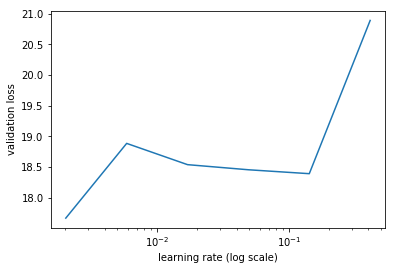

In [132]:
learn.sched.plot(n_skip=5, n_skip_end=1)

In [135]:
lr=1e-2

In [136]:
learn.fit(lr, 2, cycle_len=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=4), HTML(value='')))

epoch      trn_loss   val_loss                            
    0      20.602712  62.411911 
    1      19.327915  61.211573                           
    2      19.514895  63.115615                           
    3      19.195256  62.217851                           



[62.217851409912107]

In [138]:
learn.fit(1e-3, 1, cycle_len=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

 77%|███████▋  | 10/13 [00:09<00:02,  1.09it/s, loss=7.38]

Exception in thread Thread-96:
Traceback (most recent call last):
  File "/home/edwin/anaconda3/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/edwin/anaconda3/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/edwin/anaconda3/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



epoch      trn_loss   val_loss                            
    0      7.363672   76.543376 
    1      7.512039   77.422043                           



[77.422043457031251]

In [58]:
learn.fit(1e-2, 2)

HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

epoch      trn_loss   val_loss                            
    0      79.956019  55.280423 
    1      62.585158  42.968682                           



[42.968682403564451]

In [36]:
preds = learn.predict()

In [60]:
np.argmax(preds[0][4:])

0

In [62]:
learn.fit(1e-3, 3)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss                            
    0      44.192351  41.862801 
    1      42.029206  42.031343                           
    2      40.647221  42.236248                           



[42.236247940063478]

In [69]:
x, y = next(iter(md2.trn_dl))

In [111]:
y[0][:5]

tensor([[   0.,    0.,    0.,    0.],
        [   0.,    0.,    0.,    0.],
        [ 125.,   53.,  186.,  156.],
        [   0.,    0.,    0.,    0.],
        [   0.,    0.,    0.,    0.]], device='cuda:0')

In [100]:
y[0][0], y[1][0]

(tensor([ 0.,  0.,  0.,  0.], device='cuda:0'), tensor(2, device='cuda:0'))

In [139]:
pred = to_np(predict_batch(learn.model, x))[0]; preds[:5]

array([[-1.49043, -2.01661,  1.31339,  1.90997,  1.94613, -0.48288, -1.82699],
       [-6.19116, -5.6158 , -5.02157, -4.94285, -0.93236,  0.67037, -0.45474],
       [-8.07327, -9.20907, -8.25086, -9.00521, -1.95978,  0.15088,  1.03622],
       [-7.25198, -6.67308, -6.28137, -6.57792, -1.25009, -0.05148,  0.58813],
       [-3.10001, -2.10152, -0.78679,  0.10567,  0.88766,  0.01823, -1.96652]], dtype=float32)

In [102]:
np.argmax(pred[4:])

2

In [141]:
learn.predict()

array([[ -0.55433,  -0.94687,   0.58343, ...,  11.15897,  -2.08364,  -6.76416],
       [ -4.54896,  -4.85294,  -4.75541, ...,  -5.79892,   4.23224,  -2.24127],
       [ -6.19297,  -5.74155,  -6.31514, ..., -10.1086 ,   1.94769,   2.85262],
       ..., 
       [ -8.07822,  -7.97426,  -8.84432, ..., -17.84341,  -3.56342,  16.64902],
       [ -2.93208,  -2.66572,  -2.3424 , ...,   1.55631,   4.57896,  -7.72641],
       [ -2.95896,  -3.39325,  -2.43131, ...,  -2.91141,  -6.15534,   9.16849]], dtype=float32)

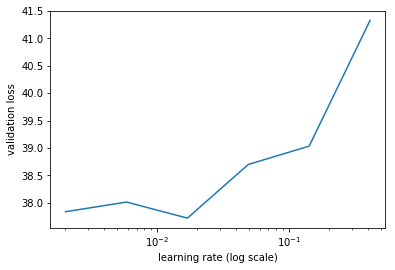

In [105]:
learn.sched.plot(n_skip=5, n_skip_end=1)

In [104]:
learn.lr_find()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss                            
    0      60.367629  21586.61375



In [106]:
lr = 1e-2

In [150]:
%page learn

In [152]:
%pprint

Pretty printing has been turned ON


In [161]:
%%ruby

a = ['a', 'do']
a.each{|a|
    print a
}
! a 
print("d")

adod

In [154]:
%%javascript

console.log("test")

<IPython.core.display.Javascript object>

In [113]:
learn.fit(lr, 10)

HBox(children=(IntProgress(value=0, description='Epoch', max=10), HTML(value='')))

epoch      trn_loss   val_loss                            
    0      21.389524  54.04739  
    1      22.608828  56.171509                           
    2      22.95136   64.509458                           
    3      22.293381  59.057624                           
    4      21.714912  56.42104                            
    5      20.971275  64.574209                           
    6      20.878493  63.342612                           
    7      20.603219  61.588492                           
    8      20.292896  62.436301                           
    9      20.105235  65.658816                           



[65.658815917968752]

In [163]:
md = ImageClassifierData.from_csv(rsna_path, 'train', SAMPLE_LABELS_BBOX_FN, bs=64, 
                                   tfms=tfms, suffix='.dcm', continuous=True)

In [164]:
learn = ConvLearner(md, f_model)

AttributeError: 'function' object has no attribute 'get_layer_groups'

In [188]:
head_reg4 = nn.Sequential(Flatten(), nn.Linear(25088,4))
learn = ConvLearner.pretrained(f_model, md, custom_head=head_reg4)
learn.opt_fn = optim.Adam
learn.crit = nn.L1Loss()

In [169]:
x, y = next(iter(md.trn_dl))

In [171]:
y[:5]

tensor([[   0.,    0.,    0.,    0.],
        [ 130.,  143.,  156.,  168.],
        [  84.,   97.,  114.,  146.],
        [   0.,    0.,    0.,    0.],
        [   0.,    0.,    0.,    0.]], device='cuda:0')

In [189]:
learn.lr_find()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss                            
    0      315.856922 5783.777031



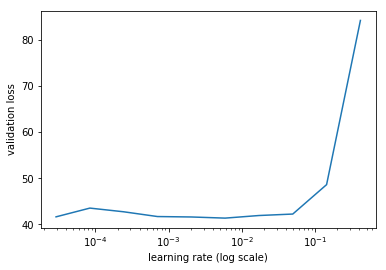

In [194]:
learn.sched.plot(n_skip=1, n_skip_end=1)

In [195]:
lr = 1e-3

In [196]:
learn.fit(lr, 2, cycle_len=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=4), HTML(value='')))

epoch      trn_loss   val_loss                            
    0      44.705571  33.951549 
    1      42.34308   31.797747                           
    2      40.964241  31.600421                           
    3      39.576971  31.403211                           



[31.403210678100585]

In [200]:
sample_bbox = pd.read_csv(SAMPLE_LABELS_BBOX_FN); sample_bbox[:5]

,patientId,bbox_corners
0,e826da48-06fe-4fe8-aa25-46d58438ab06,0 0 0 0
1,7215f3e0-f549-43f2-8fb7-9202b133d142,0 0 0 0
2,afc7efe2-5df9-4274-8df4-31eefde7b574,296.0 436.0 481.0 584.0
3,18ee3d5a-1d35-4f91-bef4-da13e40c4935,533.0 462.0 816.0 789.0
4,6e290df1-5d27-4de0-aba7-374ffe59baa8,0 0 0 0


In [237]:
preds = to_np(predict_batch(learn.model, x)); preds[:10], y[:10]

(array([[  19.38111,    7.39571,   -5.13603,  -24.68846],
        [ 131.7632 ,  109.30708,  149.28944,  136.95206],
        [  93.08678,   80.1678 ,  114.45456,  102.57616],
        [  40.0719 ,   15.10044,   35.13033,   19.25284],
        [  45.07111,    5.98193,   12.55238,   -1.46639],
        [  24.30898,    0.06381,   13.70422,   -6.65554],
        [  25.39096,   64.01064,   60.81658,   55.17228],
        [  37.07209,   15.32498,   18.81321,   17.1921 ],
        [  31.57104,   22.12539,   -1.66063,   -4.18087],
        [  50.08184,   18.69386,   67.71573,   54.54223]], dtype=float32),
 tensor([[   0.,    0.,    0.,    0.],
         [ 130.,  143.,  156.,  168.],
         [  84.,   97.,  114.,  146.],
         [   0.,    0.,    0.,    0.],
         [   0.,    0.,    0.,    0.],
         [   0.,    0.,    0.,    0.],
         [  24.,  123.,   67.,  153.],
         [   0.,    0.,    0.,    0.],
         [   0.,    0.,    0.,    0.],
         [   0.,    0.,    0.,    0.]], device='cuda

In [204]:
len(sample_bbox[sample_bbox['bbox_corners'] != '0 0 0 0'])

327

In [210]:
learn.fit(lr, 2)

HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

epoch      trn_loss   val_loss                            
    0      38.362278  32.786841 
    1      36.957084  32.620737                           



[32.620736770629883]

In [211]:
learn.lr_find()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss                            
    0      375.259919 6390.397109



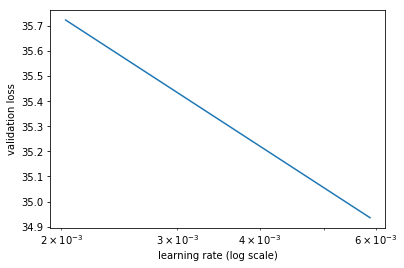

In [220]:
learn.sched.plot(5)

In [222]:
lrs = [1e-4,1e-3,1e-2]

In [223]:
learn.fit(lrs, 2)

HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

epoch      trn_loss   val_loss                            
    0      85.781717  65.973594 
    1      64.139442  38.331433                           



[38.33143295288086]

In [224]:
learn.fit(lrs, 4)

HBox(children=(IntProgress(value=0, description='Epoch', max=4), HTML(value='')))

epoch      trn_loss   val_loss                            
    0      84.408885  53.450479 
    1      64.106338  40.217639                           
    2      51.919257  37.067202                           
    3      44.4076    36.216219                           



[36.216219329833983]

In [228]:
learn.fit(lrs, 2, cycle_len=2, best_save_name='../tmp/rsna_4.pth')

HBox(children=(IntProgress(value=0, description='Epoch', max=4), HTML(value='')))

epoch      trn_loss   val_loss                            
    0      84.786784  60.316391 
    1      58.93947   36.97519                            
    2      65.933506  54.218156                           
    3      54.840605  37.263809                           



[37.263809127807619]

In [227]:
learn.save('../tmp/rsna_4.pth')

In [231]:
learn.fit(lrs, 2, cycle_len=2, best_save_name='../tmp/rsna_4.pth')

HBox(children=(IntProgress(value=0, description='Epoch', max=4), HTML(value='')))

epoch      trn_loss   val_loss                            
    0      66.832207  46.665451 
    1      46.693954  38.850382                           
    2      42.468397  47.594422                           
    3      35.783881  37.362142                           



[37.362141571044923]

In [233]:
learn.fit(lrs, 1, cycle_len=2, use_clr=(20,8))

HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

epoch      trn_loss   val_loss                            
    0      33.147152  40.751274 
    1      27.892706  37.704826                           



[37.704826202392582]

In [238]:
learn.fit(lrs, 3)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss                            
    0      56.346063  47.592695 
    1      43.026151  43.138044                           
    2      34.963676  38.972573                           



[38.972572631835938]

In [239]:
preds = to_np(predict_batch(learn.model, x)); preds[:10], y[:10]

(array([[  -2.08695,    6.53425,   11.44462,   -3.30342],
        [  92.1111 ,  101.34088,  139.42667,  195.35808],
        [  97.69611,   98.84008,  116.14307,  131.09721],
        [  27.24857,   27.63405,   29.72294,   74.05966],
        [  29.64321,   24.46686,    0.9403 ,   35.46956],
        [  -1.29996,  -15.91629,   -6.96455,   44.79155],
        [  12.48117,   88.11793,   45.11939,  113.00789],
        [  23.27729,    0.06726,   22.75672,   51.16437],
        [   5.78793,    2.38636,    2.44516,   40.39376],
        [  44.70691,   26.38728,   64.12405,   88.92078]], dtype=float32),
 tensor([[   0.,    0.,    0.,    0.],
         [ 130.,  143.,  156.,  168.],
         [  84.,   97.,  114.,  146.],
         [   0.,    0.,    0.,    0.],
         [   0.,    0.,    0.,    0.],
         [   0.,    0.,    0.,    0.],
         [  24.,  123.,   67.,  153.],
         [   0.,    0.,    0.,    0.],
         [   0.,    0.,    0.,    0.],
         [   0.,    0.,    0.,    0.]], device='cuda